# Spark Clustering the Walmart data

Let's look at a clustering example in Spark MLLib.

Here, we are going to load the mtcars dataset. This has some stats on different models of cars.  Here, we will load the CSV file as a spark dataframe, and view it.

In [1]:
# initialize Spark Session
import os
import sys
top_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
if top_dir not in sys.path:
    sys.path.append(top_dir)

from init_spark import init_spark
spark = init_spark()
spark

Initializing Spark...
Spark found in :  /Users/sujee/spark
Spark config:
	 spark.app.name=TestApp
	spark.master=local[*]
	executor.memory=2g
	spark.sql.warehouse.dir=/var/folders/lp/qm_skljd2hl4xtps5vw0tdgm0000gn/T/tmpiy_8p0ke
	some_property=some_value
Spark UI running on port 4040


In [2]:
%matplotlib inline

import time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from matplotlib import pyplot

In [3]:
t1 = time.perf_counter()
dataset = spark.read.csv("/data/walmart-triptype/train-transformed.csv.gz", header=True, inferSchema=True)
t2 = time.perf_counter()

records_count_total = dataset.count()
print("read {:,} records in {:,.2f} ms".format(records_count_total, (t2-t1)*1000))
dataset.printSchema()
dataset.show(10)

read 95,674 records in 4,208.68 ms
root
 |-- VisitNumber: integer (nullable = true)
 |-- TripType: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- NumItems: integer (nullable = true)
 |-- Return: double (nullable = true)
 |-- 1-HR PHOTO: double (nullable = true)
 |-- ACCESSORIES: double (nullable = true)
 |-- AUTOMOTIVE: double (nullable = true)
 |-- BAKERY: double (nullable = true)
 |-- BATH AND SHOWER: double (nullable = true)
 |-- BEAUTY: double (nullable = true)
 |-- BEDDING: double (nullable = true)
 |-- BOOKS AND MAGAZINES: double (nullable = true)
 |-- BOYS WEAR: double (nullable = true)
 |-- BRAS & SHAPEWEAR: double (nullable = true)
 |-- CAMERAS AND SUPPLIES: double (nullable = true)
 |-- CANDY, TOBACCO, COOKIES: double (nullable = true)
 |-- CELEBRATION: double (nullable = true)
 |-- COMM BREAD: double (nullable = true)
 |-- CONCEPT STORES: double (nullable = true)
 |-- COOK AND DINE: double (nullable = true)
 |-- DAIRY: double (nullable = true)
 |-- DS

## Creating Vectors

We'll again use the VectorAssembler class to create features from the data..

In [4]:
columns = dataset.columns
columns.remove('VisitNumber')
columns.remove('TripType')

assembler = VectorAssembler(inputCols=columns, outputCol="features")
featureVector = assembler.transform(dataset)


In [5]:
for row in featureVector.select('features').take(10):
    print("Vector: %s\n" % (str(row)))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: -1.0, 2: 1.0, 23: -1.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 2.0, 52: 1.0, 64: 1.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 28.0, 2: 1.0, 19: 2.0, 20: 1.0, 33: 1.0, 44: 1.0, 51: 18.0, 53: 4.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 3.0, 35: 1.0, 59: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 3.0, 14: 1.0, 20: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 4.0, 20: 1.0, 27: 1.0, 35: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 7.0, 11: 2.0, 33: 2.0, 52: 2.0, 64: 1.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 9.0, 22: 9.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 4.0, 14: 2.0, 20: 2.0}))

Vector: Row(features=SparseVector(70, {0: 5.0, 1: 9.0, 4: 1.0, 22: 1.0, 31: 1.0, 35: 2.0, 38: 1.0, 46: 3.0}))



Note the output. These are Sparse (not dense) Vectors.  That's because we our data IS sparse, we have relatively few of the variables at any given time.

## Running Kmeans

We know there are 39 triptypes.  So that makes a good "natural" value of k.

In [6]:
k = 39  # Number of triptypes is 39.
kmeans = KMeans().setK(k).setSeed(1)
t1 = time.perf_counter()
model = kmeans.fit(featureVector)
t2 = time.perf_counter()

wssse = model.computeCost(featureVector)

print("Kmeans : {} clusters computed in {:,.2f} ms".format( k,  ((t2-t1)*1000)))
print ("num_clusters = {},  WSSSE = {:,}".format(k, wssse))

Kmeans : 39 clusters computed in 4,548.59 ms
num_clusters = 39,  WSSSE = 2,370,357.9494931693


Let's take a look at the transformed dataset.  let's look at a distribution of our transformed dataset

In [7]:
predictions = model.transform(featureVector)
histogram = predictions.groupBy('prediction').count().orderBy('prediction')
histogram.show(40)

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  458|
|         1| 8872|
|         2|  127|
|         3| 9746|
|         4| 3120|
|         5|  845|
|         6| 7489|
|         7|  508|
|         8|  118|
|         9|  188|
|        10| 2590|
|        11|    2|
|        12|   61|
|        13|  855|
|        14| 6053|
|        15|   55|
|        16| 1209|
|        17|  223|
|        18|  540|
|        19| 1027|
|        20|  481|
|        21| 1478|
|        22| 1408|
|        23|  197|
|        24| 3779|
|        25| 5467|
|        26| 9590|
|        27| 1539|
|        28|  462|
|        29|11122|
|        30| 7628|
|        31| 1504|
|        32| 1335|
|        33|  508|
|        34|  410|
|        35| 3687|
|        36|  716|
|        37|  166|
|        38|  111|
+----------+-----+



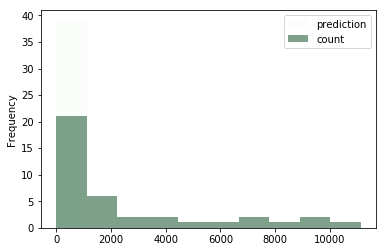

In [8]:
# histogram.toPandas().plot.bar(colormap='Greens')
histogram.toPandas().plot.hist(colormap='Greens', alpha=0.5)

## Relate Cluster Numbers to Trip Types

Is there a relationship here? Discuss the results.

Remember, clustering is trying to find "natural" patterns -- it is not a classifier, and if we are trying to classify trip type we should use a classification algorithm and not k-means.

In [9]:

for i in (range(0,38)):
    print('Cluster #' + str(i) + ':')
    predictions.filter('prediction == ' + str(i)).groupBy('TripType').count().filter("`count` >= 1").sort('count', ascending=False).show()

Cluster #0:
+--------+-----+
|TripType|count|
+--------+-----+
|      40|  389|
|      38|   30|
|      37|   26|
|      24|    5|
|      44|    3|
|      22|    2|
|      29|    1|
|      33|    1|
|      42|    1|
+--------+-----+

Cluster #1:
+--------+-----+
|TripType|count|
+--------+-----+
|       8| 2600|
|       9| 2285|
|       3|  897|
|       5|  573|
|       7|  534|
|     999|  412|
|       6|  201|
|      30|  149|
|      24|  147|
|      31|  145|
|      22|  139|
|      25|  126|
|      32|   80|
|      19|   64|
|      18|   50|
|      29|   48|
|      20|   45|
|      28|   43|
|       4|   42|
|      23|   36|
+--------+-----+
only showing top 20 rows

Cluster #2:
+--------+-----+
|TripType|count|
+--------+-----+
|      25|   81|
|      42|   20|
|      44|   12|
|      41|    6|
|      30|    2|
|       7|    1|
|      32|    1|
|       8|    1|
|     999|    1|
|      36|    1|
|      24|    1|
+--------+-----+

Cluster #3:
+--------+-----+
|TripType|count|
+-----